In [1]:
import numpy as np
import pandas as pd
import re
# from selenium import webdriver
# from selenium.webdriver import ActionChains
# from selenium.webdriver.common.keys import Keys
import time
# # 如果有 NoSuchElementException 的情況
# from selenium.common.exceptions import NoSuchElementException

# from bs4 import BeautifulSoup
import requests
import json
import datetime

import csv

import MySQLdb
import xlrd
from datetime import datetime

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier



from datetime import datetime
import datetime
import calendar
import time
from functools import reduce

from sklearn.model_selection import train_test_split


import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime

/home/js/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 建立資料表 (Table)


In [44]:
# # # # del database
# # # drop database 591_house_rentals

# # # 創database

# # import csv
# # import MySQLdb
# # import pandas as pd
# # import xlrd
# # from datetime import datetime

# # conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
# #                      user="root",         # your username
# #                      passwd="",           # your password
# # #                      db = "591_house_rentals",    # name of the data base         
# #                      use_unicode=True, 
# #                      charset="utf8mb4")
# # cur = conn.cursor()
# # cur.execute("CREATE DATABASE 591_house_rentals DEFAULT CHARACTER SET 'utf8'")
# # conn.commit()    
# # cur.close()
# # conn.close()




# # 在某一個DB創一個新的table

# import csv

# import MySQLdb
# import pandas as pd
# import xlrd
# from datetime import datetime
# # cur.execute("CREATE DATABASE web_crawler DEFAULT CHARACTER SET 'utf8'")

# conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
#                      user="root",         # your username
#                      passwd="",           # your password
#                      db = "591_house_rentals",    # name of the data base         
#                      use_unicode=True, 
#                      charset="utf8mb4")


# cur = conn.cursor()

# # ---------------------------------------------------------------------------------------------
# # # 如果数据表已经存在使用 execute() 方法删除表。
# cur.execute("DROP TABLE IF EXISTS 所有物件_20190226")

# # create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
# sql = """CREATE TABLE 所有物件_20190226 (
#          houseid VARCHAR(25) NOT NULL primary key,
#          fulladdress VARCHAR(60),
#          kind_name VARCHAR(10),
#          layout VARCHAR(20),
#          area DECIMAL(5,2),                
#          floor INT,
#          allfloor INT,

#          top_floor INT,
         
#          price INT,
#          region_name VARCHAR(5),
#          section_name VARCHAR(5),
#          address_img_title VARCHAR(30),
#          browsenum_all INT,
#          nick_name VARCHAR(3),
#          house_living VARCHAR(100),                  
#          len_living INT,
#          house_condition VARCHAR(200),
#          len_condition INT,
         
#          isvip INT,
#          user_id VARCHAR(25),
#          street_name VARCHAR(30),
#          browsenum INT,
#          cases_id VARCHAR(25),
#          checkstatus INT,
#          closed INT,
#          comment_total INT,
#          new_list_comment_total INT,
#          photoNum INT,
#          refreshtime INT,
#          shape INT,
#          social_house INT,
#          storeprice INT,
#          updatetime INT,
#          posttime VARCHAR(10),
#          mvip INT,
#          ltime TIMESTAMP,
#          is_combine INT,
#          hasimg INT,
         
         
         
         
#          補充 VARCHAR(100)
#          );"""      

# """
# top_floor : floor / allfloor  if == 1 :    ;   if != 1 :
# price : str, 去掉逗點1,500 --> int
# nick_name : 屋主 某小姐 / 房仲 某小姐  --> .split(" ")[0] --> 屋主
# len_living : --> len(data["data"]["data"][i]["living"].split(","))
# len_condition : --> len(data["data"]["data"][i]["condition"].split(","))
# """
# cur.execute(sql)


# # ---------------------------------------------------------------------------------------------
# # # 如果数据表已经存在使用 execute() 方法删除表。
# cur.execute("DROP TABLE IF EXISTS 已成交_20190226")

# # create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
# sql = """CREATE TABLE 已成交_20190226 (
#          houseid INT NOT NULL primary key,
#          days_to_deal INT,
#          browsenum INT,
#          post_time VARCHAR(10),
         
#          補充 VARCHAR(100)
#          );"""         

# """
# days_to_deal : 20天成交  --> data["data"]["data"][i]["addInfo"].split("天")[0] --> 20
# """
# cur.execute(sql)


# # ---------------------------------------------------------------------------------------------
# conn.commit()    


# cur.close()
# conn.close()

/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: Warning: (1051, "Unknown table '591_house_rentals.所有物件_20190226'")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: Warning: (1051, "Unknown table '591_house_rentals.已成交_20190226'")


## 網頁資訊擷取 - 所有物件

In [45]:
start = datetime.now()

conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "591_house_rentals",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")

cur = conn.cursor()

#設置假的瀏覽器資訊
headers = requests.utils.default_headers()
headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'


# 由於po文浮動速度太快，先紀錄大約想抓取的筆數
url = ("https://rent.591.com.tw/home/search/rsList?is_new_list=1&type=1&kind=0&searchtype=1&region=1&firstRow=0")
# 這裡解析完不是網頁而是json，所以不使用soup解讀
resp = requests.get(url, headers=headers)
#resp.text
data = resp.json()  # data = json.loads(resp.text)
data_records = int(data["records"].replace(",", ""))


# 擷取已成交的內容資訊   
for i in range(0, 15000, 30) :  # 20000  ## "共找到10,333間房屋"
    
    # 在進入下一次迴圈之前要 歸零 ，才不會讓如果下一個是null的，不小心借到上一個值
    data = None
    
    
    url = ("https://rent.591.com.tw/home/search/rsList?is_new_list=1&type=1&kind=0&searchtype=1&region=1&firstRow=%s") % i

    try :
        # 這裡解析完不是網頁而是json，所以不使用soup解讀
        resp = requests.get(url, headers=headers)
        #resp.text
        data = resp.json()  # data = json.loads(resp.text)
        # data.keys()       --->     dict_keys(['status', 'data', 'records', 'is_recom', 'deal_recom', 'online_social_user'])
        # data["data"].keys()       --->     dict_keys(['topData', 'biddings', 'data', 'page'])
        # data["data"]["topData"] 是上面banner的20個精選推薦(我要的不是那個資訊)

        # data["data"]["data"]
    except :
        
        time.sleep(10)
        
        # 這裡解析完不是網頁而是json，所以不使用soup解讀
        resp = requests.get(url, headers=headers)
        #resp.text
        data = resp.json()  # data = json.loads(resp.text)
        # data.keys()       --->     dict_keys(['status', 'data', 'records', 'is_recom', 'deal_recom', 'online_social_user'])
        # data["data"].keys()       --->     dict_keys(['topData', 'biddings', 'data', 'page'])
        # data["data"]["topData"] 是上面banner的20個精選推薦(我要的不是那個資訊)

        # data["data"]["data"]



    # 停止條件
#     if i > (int(data["records"].replace(",", "")) + 29) :
    if i > (data_records + 29) :
        break
    
    len_of_object = len(data["data"]["data"])
    for j in range(0, len_of_object) :
        houseid = data["data"]["data"][j]["houseid"]
        fulladdress = data["data"]["data"][j]["fulladdress"]
        kind_name = data["data"]["data"][j]["kind_name"]
        layout = data["data"]["data"][j]["layout"]
        area = data["data"]["data"][j]["area"]
        floor = data["data"]["data"][j]["floor"]
        allfloor = data["data"]["data"][j]["allfloor"]
        
        try :
            if floor / allfloor == 1 :
                top_floor = 1
            else :
                top_floor = 0
        except :
            top_floor = None
        
        price = int(data["data"]["data"][j]["price"].replace(",", ""))
        region_name = data["data"]["data"][j]["region_name"]
        section_name = data["data"]["data"][j]["section_name"]
        address_img_title = data["data"]["data"][j]["address_img_title"]
        browsenum_all = data["data"]["data"][j]["browsenum_all"]
        nick_name = data["data"]["data"][j]["nick_name"].split(" ")[0]
        
        house_living = data["data"]["data"][j]["living"]
        len_living = len(data["data"]["data"][j]["living"].split(","))
        
        house_condition = data["data"]["data"][j]["condition"]
        len_condition = len(data["data"]["data"][j]["condition"].split(","))
        
        
        isvip = data["data"]["data"][j]["isvip"]
        user_id = data["data"]["data"][j]["user_id"]
        street_name = data["data"]["data"][j]["street_name"]
        browsenum = data["data"]["data"][j]["browsenum"]
        cases_id = data["data"]["data"][j]["cases_id"]
        checkstatus = data["data"]["data"][j]["checkstatus"]
        closed = data["data"]["data"][j]["closed"]
        comment_total = data["data"]["data"][j]["comment_total"]
        new_list_comment_total = data["data"]["data"][j]["new_list_comment_total"]
        photoNum = data["data"]["data"][j]["photoNum"]
        refreshtime = data["data"]["data"][j]["refreshtime"]
        shape = data["data"]["data"][j]["shape"]
        social_house = data["data"]["data"][j]["social_house"]
        storeprice = data["data"]["data"][j]["storeprice"]
        updatetime = data["data"]["data"][j]["updatetime"]
        posttime = data["data"]["data"][j]["posttime"]
        mvip = data["data"]["data"][j]["mvip"]
        ltime = data["data"]["data"][j]["ltime"]
        is_combine = data["data"]["data"][j]["is_combine"]
        hasimg = data["data"]["data"][j]["hasimg"]

    
    
        sql = """
        INSERT INTO 所有物件_20190226 (houseid, fulladdress, kind_name, layout, area, floor, allfloor, top_floor, price, 
        region_name, section_name, address_img_title, browsenum_all, nick_name, house_living, len_living,
        house_condition, len_condition, 
        isvip, user_id, street_name, browsenum, cases_id, 
        checkstatus, closed, comment_total, new_list_comment_total, photoNum, 
        refreshtime, shape, social_house, storeprice, updatetime, 
        posttime, mvip, ltime, is_combine, hasimg) 
        VALUES (%s, %s, %s, %s, %s, 
                %s, %s, %s, %s, %s, 
                %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s,
                %s, %s, %s)
                
        ON DUPLICATE KEY UPDATE houseid = houseid"""

        cur.execute(sql, (houseid, fulladdress, kind_name, layout, area, floor, allfloor, top_floor, price, 
                          region_name, section_name, address_img_title, browsenum_all, nick_name, 
                          house_living, len_living, house_condition, len_condition,
                          isvip, user_id, street_name, browsenum, cases_id, 
                          checkstatus, closed, comment_total, new_list_comment_total, photoNum, 
                          refreshtime, shape, social_house, storeprice, updatetime, 
                          posttime, mvip, ltime, is_combine, hasimg))
        
    time.sleep(3)
    
    print(i)

    
    

     
        
conn.commit()    


cur.close()
conn.close()        
        
end = datetime.now()
print("所花時間 : %s" % (end - start))

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE6\\xB8...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE6\\xB8...' for column 'address_img_title' at row 1")


900
930


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1264, "Out of range value for column 'area' at row 1")


960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
1440
1470
1500


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE8\\xB3...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE8\\xB3...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8E\\xA1\\xE5\\x8A...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8E\\xA1\\xE5\\x8A...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8C\\xB8\\xF0\\x9F...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipyker

1530


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\xAD...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\xAD...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE5\\x85...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE5\\x85...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\xBC...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipyker

1560
1590
1620
1650
1680
1710


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE4\\xB8...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE4\\xB8...' for column 'address_img_title' at row 1")


1740


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE6\\x96...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE6\\x96...' for column 'address_img_title' at row 1")


1770
1800
1830
1860
1890


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE7\\xA8...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE7\\xA8...' for column 'address_img_title' at row 1")


1920
1950
1980
2010
2040
2070
2100
2130
2160
2190
2220
2250
2280
2310
2340


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE9\\x81...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE9\\x81...' for column 'address_img_title' at row 1")


2370
2400
2430


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE6\\x8E...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE6\\x8E...' for column 'address_img_title' at row 1")


2460
2490
2520
2550


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE5\\x8F...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE5\\x8F...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\x8D...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\x8D...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\xA5...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipyker

2580


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE4\\xBA...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE4\\xBA...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA510...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA510...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\x9D...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

2610
2640
2670
2700
2730
2760
2790
2820
2850
2880
2910
2940
2970
3000
3030


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE5\\x9D...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE5\\x9D...' for column 'address_img_title' at row 1")


3060
3090
3120
3150
3180
3210
3240


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x98' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x98' for column 'address_img_title' at row 1")


3270
3300
3330
3360
3390
3420
3450
3480
3510
3540
3570
3600


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE9\\xAB...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE9\\xAB...' for column 'address_img_title' at row 1")


3630
3660


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\xAF\\xE6\\xB0...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\xAF\\xE6\\xB0...' for column 'address_img_title' at row 1")


3690
3720
3750
3780
3810
3840
3870
3900
3930
3960
3990
4020
4050


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x97\\xE6\\x99...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x97\\xE6\\x99...' for column 'address_img_title' at row 1")


4080
4110
4140
4170
4200
4230
4260
4290
4320
4350
4380
4410
4440
4470
4500


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\x8C...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE6\\x8C...' for column 'address_img_title' at row 1")


4530


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE5\\xBE...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE5\\xBE...' for column 'address_img_title' at row 1")


4560
4590


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8C\\xB2\\xE5\\xA4...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8C\\xB2\\xE5\\xA4...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\xAB\\xE7\\xBE...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\xAB\\xE7\\xBE...' for column 'address_img_title' at row 1")


4620
4650
4680
4710
4740
4770
4800
4830
4860


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8C\\xB33\\xE6...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8C\\xB33\\xE6...' for column 'address_img_title' at row 1")


4890
4920
4950


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE9\\x89...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE9\\x89...' for column 'address_img_title' at row 1")


4980
5010
5040
5070
5100
5130
5160
5190
5220
5250
5280
5310
5340
5370
5400
5430
5460


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE9\\x9B...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE9\\x9B...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE8\\xA3...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE8\\xA3...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE5\\xBF...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipyker

5490


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x963\\xE6...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x963\\xE6...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE7\\x92...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE7\\x92...' for column 'address_img_title' at row 1")


5520
5550
5580
5610
5640
5670
5700
5730
5760
5790
5820
5850
5880
5910
5940


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE9\\x95...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE9\\x95...' for column 'address_img_title' at row 1")


5970
6000
6030
6060
6090
6120
6150
6180
6210
6240


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\xA0\\xE5\\x8F...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\xA0\\xE5\\x8F...' for column 'address_img_title' at row 1")


6270
6300
6330
6360
6390


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE8\\x8F...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8D\\xE8\\x8F...' for column 'address_img_title' at row 1")


6420


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\x86MR...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\x86MR...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\x86\\xE5\\x85...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\x86\\xE5\\x85...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\x86\\xE7\\x8D...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

6450
6480
6510
6540
6570
6600
6630


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE5\\x83...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8D\\x8E\\xE5\\x83...' for column 'address_img_title' at row 1")


6660
6690
6720


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x9D\\xE4\\xBD...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x9D\\xE4\\xBD...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8C\\xBA\\xE5\\xA5...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8C\\xBA\\xE5\\xA5...' for column 'address_img_title' at row 1")


6750
6780
6810
6840
6870
6900
6930
6960
6990
7020
7050
7080
7110
7140
7170
7200


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\xA0\\xE6\\x9D...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x8F\\xA0\\xE6\\x9D...' for column 'address_img_title' at row 1")


7230
7260
7290
7320
7350
7380
7410
7440
7470
7500
7530
7560
7590


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE5\\xAE...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE5\\xAE...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE6\\xAD...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE6\\xAD...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x92\\x96\\xE5\\xB0...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipyker

7620
7650
7680
7710
7740


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x9A\\x87\\xE6\\xAD...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x9A\\x87\\xE6\\xAD...' for column 'address_img_title' at row 1")


7770
7800
7830
7860
7890
7920
7950
7980
8010
8040
8070
8100
8130
8160
8190


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE5\\x96...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE5\\x96...' for column 'address_img_title' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE7\\xA7...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x94\\xA5\\xE7\\xA7...' for column 'address_img_title' at row 1")


8220
8250
8280
8310
8340
8370
8400
8430
8460
8490
8520
8550
8580
8610
8640
8670
8700
8730
8760
8790
8820
8850
8880
8910
8940
8970
9000
9030
9060
9090
9120
9150
9180
9210
9240
9270
9300
9330
9360
9390
9420
9450
9480
9510
9540
9570
9600
9630
9660
9690
9720
9750
9780
9810
9840
9870
9900
9930
9960
9990
10020
10050
10080
10110
10140
10170
10200


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x91\\x8D\\xE6\\x97...' for column 'fulladdress' at row 1")
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: Warning: (1366, "Incorrect string value: '\\xF0\\x9F\\x91\\x8D\\xE6\\x97...' for column 'address_img_title' at row 1")


10230
10260
10290
10320
10350
10380
10410
10440
10470
10500
10530
10560
10590
10620
10650
10680
10710
10740
10770
10800
10830
10860
所花時間 : 0:22:19.727787


In [46]:
int(data["records"].replace(",", ""))

10844

In [47]:
time.sleep(100)

## 網頁資訊擷取 - 已成交

In [48]:
start = datetime.now()

conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "591_house_rentals",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()


#設置假的瀏覽器資訊

headers = requests.utils.default_headers()
headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
  

# 由於po文浮動速度太快，先紀錄大約想抓取的筆數
url = ("https://rent.591.com.tw/home/search/rsList?is_new_list=1&type=&kind=&searchtype=1&region=1&shType=clinch&firstRow=0")

# 這裡解析完不是網頁而是json，所以不使用soup解讀
resp = requests.get(url, headers=headers)
#resp.text
data = resp.json()  # data = json.loads(resp.text)
data_records = int(data["records"].replace(",", ""))



# 擷取已成交的內容資訊
for i in range(0, 45000, 50) :  # 300000     45000
    # 在進入下一次迴圈之前要 歸零 ，才不會讓如果下一個是null的，不小心借到上一個值
    data = None
    

    
    url = ("https://rent.591.com.tw/home/search/rsList?is_new_list=1&type=&kind=&searchtype=1&region=1&shType=clinch&firstRow=%s") % i

    try :
        # 這裡解析完不是網頁而是json，所以不使用soup解讀
        resp = requests.get(url, headers=headers)
        #resp.text
        data = resp.json()  # data = json.loads(resp.text)
        # data.keys()       --->     dict_keys(['status', 'data', 'records', 'is_recom', 'deal_recom', 'online_social_user'])
        # data["data"].keys()       --->     dict_keys(['topData', 'biddings', 'data', 'page'])
        # data["data"]["topData"] 是上面banner的20個精選推薦(我要的不是那個資訊)

        # data["data"]["data"]
        
    except :
        
        time.sleep(10)
        
        # 這裡解析完不是網頁而是json，所以不使用soup解讀
        resp = requests.get(url, headers=headers)
        #resp.text
        data = resp.json()  # data = json.loads(resp.text)
        # data.keys()       --->     dict_keys(['status', 'data', 'records', 'is_recom', 'deal_recom', 'online_social_user'])
        # data["data"].keys()       --->     dict_keys(['topData', 'biddings', 'data', 'page'])
        # data["data"]["topData"] 是上面banner的20個精選推薦(我要的不是那個資訊)

        # data["data"]["data"]
        
    '''
    # 存放變數
    houseid INT NOT NULL primary key,
    days_to_deal INT,
    browsenum INT,
    post_time VARCHAR(10),
    
    補充 VARCHAR(100)
    '''
    
    """
    days_to_deal : 20天成交  --> .split("天")[0] --> 20
    """

    # 停止條件
    if i > (data_records + 49) :
        break
        
    len_of_object = len(data["data"]["data"])
    for j in range(0, len_of_object) :
        houseid = data["data"]["data"][j]["houseid"]
        days_to_deal = int(str(data["data"]["data"][j]["addInfo"]).split("天")[0])
        browsenum = data["data"]["data"][j]["browsenum"]
        post_time = data["data"]["data"][j]["posttime"]
        
    
        sql = """
        INSERT INTO 已成交_20190226 (houseid, days_to_deal, browsenum, post_time) 
        VALUES (%s, %s, %s, %s)
        ON DUPLICATE KEY UPDATE houseid = houseid        
        """

        cur.execute(sql, (houseid, days_to_deal, browsenum, post_time))
        
        # 先匯進去資料庫吧
        conn.commit() 
    
    time.sleep(3)
        
    print(i)

    
    

     
        
# conn.commit()    


cur.close()
conn.close()        
        
end = datetime.now()
print("所花時間 : %s" % (end - start))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

## 爬文到約40500時出錯，出現連線逾時，可能是因為沒sleep導致被鎖
> 所以修正如下 ： 
> 1. sleep(3)
> 2. 先commit 確定匯入資料庫，避免到尾聲結果因為出錯就什麼都沒會到資料庫，結果還被鎖

### df_所有物件

In [ ]:
conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "591_house_rentals",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")

cur = conn.cursor()
sql = "SELECT * FROM 所有物件"

df = pd.read_sql(sql, conn)
conn.close()

In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# df_predict = ['kind_name', 'area', 'floor',
#        'allfloor', 'top_floor', 'price', 'region_name', 'section_name',
#        'browsenum_all', 'nick_name',
#        'len_living', 'len_condition']


df_predict_cols = ['area', 'floor', 'allfloor', 'top_floor', 'price',
           'browsenum_all', 'len_living', 'len_condition']



import numpy as np

cm = np.corrcoef(df[df_predict_cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = ".2f", annot_kws = {"size" : 10},
                 linewidths = 0.5,
                 vmin = -1.0, vmax = 1.0,
                 cmap="YlGnBu",
                yticklabels = df_predict_cols, xticklabels = df_predict_cols)



In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt




plt.scatter(df["area"], df["price"], color = 'dodgerblue')
plt.xlabel("area")
plt.ylabel("price")
plt.legend(loc = 'upper left', frameon = False)

plt.show()


In [ ]:
set(df["kind_name"])

In [ ]:
# plt.rcParams["font.sans-serif"] = ["SimHei"]
# plt.rcParams["axes.unicode_minus"] = False

In [ ]:
# # 解決中文字顯示問題

# # a. 首先進入matplotlibrc 預設路徑

# # 確認目前是抓哪個字體 - find  matplotlib default font 
# from matplotlib.font_manager import findfont, FontProperties  
# print(findfont(FontProperties(family=FontProperties().get_family())))
# print("--")
# # 查詢字體設定檔結果
# import matplotlib
# print(matplotlib.matplotlib_fname())

# # b. 用記事本開啟 matplotlibrc 設定檔 : 將font.family與font.serif註解(#)移除，並在font.serif後方加入Microsoft JhengHei

# # c. 刪除.matplotlib快取資料夾
# """
# cd /home/您的使用者名稱/.cache
# rm -rf matplotlib
# """
# #d. 放入字體至matplotlib指定字體路徑 - 將msj文字檔(載點，為其他網友提供)下載，以msj命名之，在儲存到以下路徑資料夾 ：
# """
# /home/您的使用者名稱/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf
# """
# # mv /home/js/下載/msj.ttf /home/js/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/msj.ttf 

# # e. 使用rcParams 參數指定字體 - 開啟Python-IDE（本處使用Spyder當作操作IDE），執行下述程式:
# from matplotlib.font_manager import FontProperties

# import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
# # plt.rcParams['font.family'] = 'sans-serif' 
# plt.rcParams['axes.unicode_minus'] = False

# # plt.rcParams['font.sans-serif']=['SimHei'] 

# plt.plot((1,2,3),(4,3,-1))
# plt.title("聲量圖")
# plt.ylabel("文章數量")
# plt.xlabel("品牌名稱") 
# plt.show()

In [ ]:
# myfont = FontProperties(fname=r'/home/js/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/msj.ttf')

# fontproperties=myfont

In [ ]:
colors = ['yellow', 'c', 'dodgerblue', 'pink', 'r', 'g']

其他 = plt.scatter(df.loc[df["kind_name"] == "其他", "area"], df.loc[df["kind_name"] == "其他", "price"], marker='o', color=colors[0])
分租套房 = plt.scatter(df.loc[df["kind_name"] == "分租套房", "area"], df.loc[df["kind_name"] == "分租套房", "price"], marker='o', color=colors[1])
整層住家 = plt.scatter(df.loc[df["kind_name"] == "整層住家", "area"], df.loc[df["kind_name"] == "整層住家", "price"], marker='o', color=colors[2])
獨立套房 = plt.scatter(df.loc[df["kind_name"] == "獨立套房", "area"], df.loc[df["kind_name"] == "獨立套房", "price"], marker='o', color=colors[3])
車位 = plt.scatter(df.loc[df["kind_name"] == "車位", "area"], df.loc[df["kind_name"] == "車位", "price"], marker='o', color=colors[4])
雅房 = plt.scatter(df.loc[df["kind_name"] == "雅房", "area"], df.loc[df["kind_name"] == "雅房", "price"], marker='o', color=colors[5])

"""
Double room 分租套房
Whole floor home 整層住家
studio 套房
parking space 車位
Bedsit 雅房
"""
plt.legend((其他, 分租套房, 整層住家, 獨立套房, 車位, 雅房),
           ('其他', '分租套房', '整層住家', '獨立套房', '車位', '雅房'),
           scatterpoints=1,
           loc='upper left',
           fontsize = 15,
           frameon = False)


from pylab import rcParams
rcParams['figure.figsize'] = 10,10

plt.xlabel('area(坪數)', fontsize=18)
plt.ylabel('price(價錢 NTD)', fontsize=18)

plt.style.use('ggplot')
plt.show()


In [ ]:
conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "591_house_rentals",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")

cur = conn.cursor()
sql = """SELECT kind_name, 
count(*) as count
FROM 所有物件
GROUP BY kind_name
"""

df_area_price_kindname = pd.read_sql(sql, conn)
conn.close()

# df_area_price_kindname["kind_name"] = df_area_price_kindname["kind_name"].replace("其他", "others")
# df_area_price_kindname["kind_name"] = df_area_price_kindname["kind_name"].replace("分租套房", "Double room")
# df_area_price_kindname["kind_name"] = df_area_price_kindname["kind_name"].replace("整層住家", "whole floor")
# df_area_price_kindname["kind_name"] = df_area_price_kindname["kind_name"].replace("獨立套房", "indp studio")
# df_area_price_kindname["kind_name"] = df_area_price_kindname["kind_name"].replace("車位", "parking space")
# df_area_price_kindname["kind_name"] = df_area_price_kindname["kind_name"].replace("雅房", "Bedsit")
df_area_price_kindname

In [ ]:
# df["kind_name"].value_counts().plot(kind='bar')

ax = df["kind_name"].value_counts().plot(kind='bar', figsize=(10,7),
                                        color="dodgerblue", fontsize=13);  # color="coral"
ax.set_alpha(0.8)
ax.set_title("房型", fontsize=18)
ax.set_ylabel("數量", fontsize=18);
# ax.set_yticks([0, 5, 10, 15, 20])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')
    
# http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

In [ ]:
# conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
#                      user="root",         # your username
#                      passwd="",           # your password
#                      db = "591_house_rentals",    # name of the data base         
#                      use_unicode=True, 
#                      charset="utf8")

# cur = conn.cursor()

# x = "屋主"

# sql = """
# SELECT *
# FROM 所有物件
# where nick_name = '%s'
# """ % x

# pd.read_sql(sql, conn)
# # df_身份



def 身份(x) :
    conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                         user="root",         # your username
                         passwd="",           # your password
                         db = "591_house_rentals",    # name of the data base         
                         use_unicode=True, 
                         charset="utf8")

    cur = conn.cursor()
    
    x = str(x)
    sql = """SELECT price, count(*)
    FROM 所有物件
    WHERE nick_name = '%s'
    GROUP BY price
    """ % x
    
    df_身份 = pd.read_sql(sql, conn)
    print("經辦件數 : %s " % sum(df_身份["count(*)"]))
    conn.close()

    
    return df_身份.hist(column='price', bins=200) #, print("經辦件數 : " % sum(df_身份["count(*)"]))
# https://stackoverflow.com/questions/42496508/histogram-on-pandas-column/42496995

In [ ]:
身份("仲介")

In [ ]:
身份("屋主")

In [ ]:
身份("代理人")

In [ ]:
colors = ['yellow', 'c', 'dodgerblue', 'pink', 'r', 
          'g', 'sandybrown', 'firebrick', 'lightgray', 'orchid',
          'lime', 'slateblue']

中正區 = plt.scatter(df.loc[df["section_name"] == "中正區", "area"], df.loc[df["section_name"] == "中正區", "price"], marker='o', color=colors[0])
大同區 = plt.scatter(df.loc[df["section_name"] == "大同區", "area"], df.loc[df["section_name"] == "大同區", "price"], marker='o', color=colors[1])
中山區 = plt.scatter(df.loc[df["section_name"] == "中山區", "area"], df.loc[df["section_name"] == "中山區", "price"], marker='o', color=colors[2])
松山區 = plt.scatter(df.loc[df["section_name"] == "松山區", "area"], df.loc[df["section_name"] == "松山區", "price"], marker='o', color=colors[3])
大安區 = plt.scatter(df.loc[df["section_name"] == "大安區", "area"], df.loc[df["section_name"] == "大安區", "price"], marker='o', color=colors[4])

萬華區 = plt.scatter(df.loc[df["section_name"] == "萬華區", "area"], df.loc[df["section_name"] == "萬華區", "price"], marker='o', color=colors[5])
信義區 = plt.scatter(df.loc[df["section_name"] == "信義區", "area"], df.loc[df["section_name"] == "信義區", "price"], marker='o', color=colors[6])
士林區 = plt.scatter(df.loc[df["section_name"] == "士林區", "area"], df.loc[df["section_name"] == "士林區", "price"], marker='o', color=colors[7])
北投區 = plt.scatter(df.loc[df["section_name"] == "北投區", "area"], df.loc[df["section_name"] == "北投區", "price"], marker='o', color=colors[8])
內湖區 = plt.scatter(df.loc[df["section_name"] == "內湖區", "area"], df.loc[df["section_name"] == "內湖區", "price"], marker='o', color=colors[9])

南港區 = plt.scatter(df.loc[df["section_name"] == "南港區", "area"], df.loc[df["section_name"] == "南港區", "price"], marker='o', color=colors[10])
文山區 = plt.scatter(df.loc[df["section_name"] == "文山區", "area"], df.loc[df["section_name"] == "文山區", "price"], marker='o', color=colors[11])



plt.legend((中正區, 大同區, 中山區, 松山區, 大安區, 萬華區, 信義區, 士林區, 北投區, 內湖區, 南港區, 文山區),
           ('中正區', '大同區', '中山區', '松山區', '大安區', '萬華區', '信義區', '士林區', '北投區', '內湖區', '南港區', '文山區'),
           scatterpoints=1,
           loc='upper left',
           fontsize = 15,
           frameon = False)


from pylab import rcParams
rcParams['figure.figsize'] = 10,10

plt.style.use('ggplot')
plt.show()

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")

# Load an example dataset with long-form data
fmri = df

# Plot the responses for different events and regions
sns.lineplot(x=df["area"], y=df["price"],
             hue=df["section_name"], style="event",
             data=fmri)

In [ ]:
ax = df["section_name"].value_counts().plot(kind='bar', figsize=(10,7),
                                        color="dodgerblue", fontsize=13);  # color="coral"
ax.set_alpha(0.8)
ax.set_title("行政區", fontsize=18)
ax.set_ylabel("數量", fontsize=18);
# ax.set_yticks([0, 5, 10, 15, 20])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

## seaborn - 盒鬚圖

In [ ]:
df_section_eng = df
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("區", ""))

df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("中山", "Zhongshan"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("大安", "Daan"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("信義", "Xinyi"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("內湖", "Neihu"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("士林", "Shilin"))

df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("中正", "Zhongzheng"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("北投", "Beitou"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("松山", "Songshan"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("文山", "Wenshan"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("大同", "Datong"))

df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("南港", "Nangang"))
df_section_eng["section_name"] = df_section_eng["section_name"].apply(lambda x: x.replace("萬華", "Wanhua"))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
tips = df_section_eng
ax = sns.boxplot(x="section_name", y="price",
                 data=df_section_eng, palette="Set3")

# Select which box you want to change    
mybox = ax.artists[2]

# Change the appearance of that box
# mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
mybox.set_linewidth(3)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
tips = df_section_eng
ax = sns.boxplot(x="allfloor", y="price",
                 data=df_section_eng, palette="Set3")

# Select which box you want to change    
mybox = ax.artists[2]

# Change the appearance of that box
# mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
mybox.set_linewidth(3)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
tips = df_section_eng
ax = sns.boxplot(x="floor", y="price",
                 data=df_section_eng, palette="Set3")

# Select which box you want to change    
mybox = ax.artists[2]

# Change the appearance of that box
# mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
mybox.set_linewidth(3)

plt.show()

In [ ]:
df_section_eng.loc[df_section_eng["kind_name"] == "其他", :]

In [ ]:
df_section_eng = df

df_section_eng["nick_name"] = df_section_eng["nick_name"].apply(lambda x: x.replace("屋主", "owner"))
df_section_eng["nick_name"] = df_section_eng["nick_name"].apply(lambda x: x.replace("仲介", "realtor"))
df_section_eng["nick_name"] = df_section_eng["nick_name"].apply(lambda x: x.replace("代理人", "agent"))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
tips = df_section_eng
ax = sns.boxplot(x="nick_name", y="price",
                 data=df_section_eng, palette="Set3")

# Select which box you want to change    
mybox = ax.artists[2]

# Change the appearance of that box
# mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
mybox.set_linewidth(3)

plt.show()

In [ ]:
df.describe()

### df_已成交

## 已成交

In [ ]:
conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "591_house_rentals",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")

cur = conn.cursor()
sql = "SELECT * FROM 已成交"

df_已成交 = pd.read_sql(sql, conn)
conn.close()
df_已成交

In [ ]:
df_已成交.describe()

In [ ]:
df_已成交["days_to_deal"].median()

### 由圖，此為右偏分佈

> meadian == 10 < mean == 13.792513

In [ ]:
df_已成交.hist(column='days_to_deal', bins=100)

In [ ]:
df_predict

## 預測模型 ： price(價錢)為 Y

In [ ]:
df

In [ ]:
df.columns

In [ ]:
df_predict = df
# 填補top_floor缺失值
df_predict["top_floor"] = df_predict["top_floor"].fillna(0)

# 去掉較大坪數的少數值
df_predict = df_predict.loc[df_predict["area"] <= 150, :]

# ohe : for section_name
# encoding in dummy variable
df_predict_section_dummies = pd.get_dummies(df_predict['section_name'], prefix = 'Section') # prefix 即 column name
df_predict = pd.concat([df_predict, df_predict_section_dummies], axis = 1)

# removing the title variable
df_predict.drop('section_name', axis = 1, inplace = True)

#------

# ohe : for kind_name
# encoding in dummy variable
df_predict_kind_dummies = pd.get_dummies(df_predict['kind_name'], prefix = 'kind') # prefix 即 column name
df_predict = pd.concat([df_predict, df_predict_kind_dummies], axis = 1)

# removing the title variable
df_predict.drop('kind_name', axis = 1, inplace = True)

#------

# ohe : for nick_name
# encoding in dummy variable
df_predict_nick_dummies = pd.get_dummies(df_predict['nick_name'], prefix = 'contact') # prefix 即 column name
df_predict = pd.concat([df_predict, df_predict_nick_dummies], axis = 1)

# removing the title variable
df_predict.drop('nick_name', axis = 1, inplace = True)

df_predict

In [ ]:
df_predict.columns

In [ ]:
# df_predict = ['kind_name', 'area', 'floor',
#        'allfloor', 'top_floor', 'price', 'region_name', 'section_name',
#        'browsenum_all', 'nick_name',
#        'len_living', 'len_condition']


df_predict_cols = ['area', 'floor', 'allfloor', 'top_floor', 'price',
           'browsenum_all', 'len_living', 'len_condition', 'Section_中山區', 'Section_中正區',
       'Section_信義區', 'Section_內湖區', 'Section_北投區', 'Section_南港區',
       'Section_士林區', 'Section_大同區', 'Section_大安區', 'Section_文山區',
       'Section_松山區', 'Section_萬華區', 'kind_其他', 'kind_分租套房', 'kind_整層住家',
       'kind_獨立套房', 'kind_車位', 'kind_雅房', 'contact_代理人', 'contact_仲介', 'contact_屋主']

In [ ]:
# # seaborn圖表如何顯示中文?
# from matplotlib.font_manager import FontProperties
# import seaborn as sns
# myfont=FontProperties(fname=r'C:\Users\howar\Desktop\msj.ttf',size=14)
# sns.set(font=myfont.get_family())
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
# cities_counter = [('好棒', 285), ('給我', 225), ('不要', 163), ('細柔', 136), ('吃飯', 130), ('小小', 124), ('深圳', 88), ('温州', 67), ('小知', 66), ('大之', 45)]
# sns.set_color_codes("pastel")
# sns.barplot(x=[k for k, _ in cities_counter[:10]], y=[v for _, v in cities_counter[:10]])

In [ ]:
import numpy as np

cm = np.corrcoef(df_predict[df_predict_cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = ".2f", annot_kws = {"size" : 10},
                 linewidths = 0.5,
                 vmin = -1.0, vmax = 1.0,
                 cmap="YlGnBu",
                yticklabels = df_predict_cols, xticklabels = df_predict_cols)

In [ ]:
col_for_prediction = ["area", "allfloor", "browsenum_all", 'Section_中山區', 'Section_中正區',
       'Section_信義區', 'Section_內湖區', 'Section_北投區', 'Section_南港區',
       'Section_士林區', 'Section_大同區', 'Section_大安區', 'Section_文山區',
       'Section_松山區', 'Section_萬華區', 'kind_其他', 'kind_分租套房', 'kind_整層住家',
       'kind_獨立套房', 'kind_車位', 'kind_雅房', 'contact_代理人', 'contact_仲介', 'contact_屋主']

X = df_predict.loc[:, col_for_prediction]
y = df_predict["price"]


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 87)

In [ ]:

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

## 把價錢的單位變成千元

In [ ]:
df_predict_thousand_dollars = df_predict
df_predict_thousand_dollars["price"] = df_predict_thousand_dollars["price"] / 1000

In [ ]:
col_for_prediction = ["area", "allfloor", "browsenum_all", 'Section_中山區', 'Section_中正區',
       'Section_信義區', 'Section_內湖區', 'Section_北投區', 'Section_南港區',
       'Section_士林區', 'Section_大同區', 'Section_大安區', 'Section_文山區',
       'Section_松山區', 'Section_萬華區', 'kind_其他', 'kind_分租套房', 'kind_整層住家',
       'kind_獨立套房', 'kind_車位', 'kind_雅房', 'contact_代理人', 'contact_仲介', 'contact_屋主']

X = df_predict_thousand_dollars.loc[:, col_for_prediction]
y = df_predict_thousand_dollars["price"]


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 87)

In [ ]:

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

## 移除車位

In [ ]:
df_predict_rm_parking = df_predict_thousand_dollars
df_predict_rm_parking = df_predict_rm_parking.loc[df_predict_rm_parking["kind_車位"] != 1, :]

In [ ]:
col_for_prediction = ["area", "allfloor", "browsenum_all", 'Section_中山區', 'Section_中正區',
       'Section_信義區', 'Section_內湖區', 'Section_北投區', 'Section_南港區',
       'Section_士林區', 'Section_大同區', 'Section_大安區', 'Section_文山區',
       'Section_松山區', 'Section_萬華區', 'kind_其他', 'kind_分租套房', 'kind_整層住家',
       'kind_獨立套房', 'kind_雅房', 'contact_代理人', 'contact_仲介', 'contact_屋主']

X = df_predict_rm_parking.loc[:, col_for_prediction]
y = df_predict_rm_parking["price"]


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 87)

In [ ]:

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

## 21 days

In [ ]:
conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "591_house_rentals",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")

cur = conn.cursor()
sql = """SELECT 所有物件.houseid, fulladdress, kind_name, layout, area, floor,
       allfloor, top_floor, price, region_name, section_name,
       address_img_title, browsenum_all, nick_name, house_living,
       len_living, house_condition, len_condition, 已成交.days_to_deal, 已成交.browsenum, 已成交.post_time
FROM 所有物件
INNER JOIN 已成交
ON 所有物件.houseid = 已成交.houseid
WHERE 已成交.days_to_deal <= 21
"""

df_deal_21days = pd.read_sql(sql, conn)
conn.close()
df_deal_21days

# df_deal_21days = pd.merge(df, df_已成交, how = "inner", on = ["houseid"])
# df_deal_21days

In [ ]:
df_deal_21days.columns

In [ ]:
df_predict_deal_21days = df_deal_21days
# 填補top_floor缺失值
df_predict_deal_21days["top_floor"] = df_predict_deal_21days["top_floor"].fillna(0)

# 去掉較大坪數的少數值
df_predict_deal_21days = df_predict_deal_21days.loc[df_predict_deal_21days["area"] <= 150, :]

# ohe
# encoding in dummy variable
df_predict_deal_21days_section_dummies = pd.get_dummies(df_predict_deal_21days['section_name'], prefix = 'Section') # prefix 即 column name
df_predict_deal_21days = pd.concat([df_predict_deal_21days, df_predict_deal_21days_section_dummies], axis = 1)

# removing the title variable
df_predict_deal_21days.drop('section_name', axis = 1, inplace = True)
df_predict_deal_21days

In [ ]:
df_predict_deal_21days.isnull().sum()

In [ ]:
col_for_prediction = ["area", "allfloor", "browsenum_all", 'Section_中山區', 'Section_中正區',
       'Section_信義區', 'Section_北投區', 'Section_南港區',
       'Section_士林區', 'Section_大同區', 'Section_大安區', 'Section_文山區',
       'Section_松山區']

X = df_predict_deal_21days.loc[:, col_for_prediction]
y = df_predict_deal_21days["price"]


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 87)

In [ ]:

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
print("\nfloor == 99 表示出租整棟 ; floor == 100 表示出租頂樓加蓋 \n")
print("出租整棟 共有 : %s 件" % len(df.loc[df["floor"] == 99, ["floor"]]))
print("出租頂樓加蓋 共有 : %s 件" % len(df.loc[df["floor"] == 100, ["floor"]]))

df.loc[df["floor"] > 33, :]

In [ ]:
df[df["floor"] == 100]

## seaborn

### box plot 盒鬚圖

> http://seaborn.pydata.org/generated/seaborn.boxplot.html

-------------------------------
# 第二次建模

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier



from datetime import datetime
import datetime
import calendar
import time
from functools import reduce

from sklearn.model_selection import train_test_split


import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime

from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import xgboost
from collections import OrderedDict

/home/js/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "591_house_rentals",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")
cur = conn.cursor()

sql = """SELECT * FROM 所有物件_20190220
"""    

df_20190220 = pd.read_sql(sql, conn)

conn.close()      

In [5]:
df_20190220.shape

(10494, 39)

In [6]:
df_20190220.columns

Index(['houseid', 'fulladdress', 'kind_name', 'layout', 'area', 'floor',
       'allfloor', 'top_floor', 'price', 'region_name', 'section_name',
       'address_img_title', 'browsenum_all', 'nick_name', 'house_living',
       'len_living', 'house_condition', 'len_condition', 'isvip', 'user_id',
       'street_name', 'browsenum', 'cases_id', 'checkstatus', 'closed',
       'comment_total', 'new_list_comment_total', 'photoNum', 'refreshtime',
       'shape', 'social_house', 'storeprice', 'updatetime', 'posttime', 'mvip',
       'ltime', 'is_combine', 'hasimg', '補充'],
      dtype='object')

In [7]:
# 調整欄位位置
df_20190220 = pd.DataFrame(df_20190220, columns = ['price', 'houseid', 'fulladdress', 'kind_name', 'layout', 'area', 'floor',
       'allfloor', 'top_floor', 'region_name', 'section_name',
       'address_img_title', 'browsenum_all', 'nick_name', 'house_living',
       'len_living', 'house_condition', 'len_condition', 'isvip', 'user_id',
       'street_name', 'browsenum', 'cases_id', 'checkstatus', 'closed',
       'comment_total', 'new_list_comment_total', 'photoNum', 'refreshtime',
       'shape', 'social_house', 'storeprice', 'updatetime', 'posttime', 'mvip',
       'ltime', 'is_combine', 'hasimg', '補充']) # 指定欄標籤排序


In [8]:
df = df_20190220.copy()

In [9]:
types = np.array(df.dtypes)
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ["類型"]
types_df_count = pd.DataFrame(types_df["類型"].value_counts())
types_df_count.columns = ["計數"]
types_df_count

,計數
int64,24
object,12
float64,2
datetime64[ns],1


In [10]:
catedorical_features = ["fulladdress",
# "kind_name",
"layout",
# "region_name",
"section_name",
"address_img_title",
# "nick_name",
"house_living",
"house_condition",
"street_name",
"posttime"] # user_id, cases_id

col_except_y = [col for col in df.columns
               if col not in ["price"]]

df.describe()

,price,houseid,area,floor,allfloor,top_floor,browsenum_all,len_living,len_condition,isvip,...,new_list_comment_total,photoNum,refreshtime,shape,social_house,storeprice,updatetime,mvip,is_combine,hasimg
count,10494.000000,1.049400e+04,10494.000000,10494.000000,10494.000000,10105.000000,10494.000000,10494.000000,10494.000000,10494.000000,...,10494.000000,10494.000000,1.049400e+04,10494.000000,10494.0,10494.0,1.049400e+04,10494.000000,10494.000000,10494.000000
mean,39920.593673,7.281119e+06,27.525605,8.593482,8.895750,0.176645,382.732990,4.548885,12.966648,0.139032,...,0.135697,9.379360,1.550350e+09,1.723175,0.0,0.0,1.549776e+09,0.060511,0.020869,0.981894
std,43940.194659,3.155599e+05,27.259270,17.842529,5.509269,0.381387,694.075153,2.409526,3.930036,0.345996,...,0.586448,4.111507,9.751040e+05,0.744165,0.0,0.0,1.422133e+06,0.238442,0.142953,0.133340
min,999.000000,1.135496e+06,1.000000,-2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.510719e+09,0.000000,0.0,0.0,1.488255e+09,0.000000,0.000000,0.000000
25%,12000.000000,7.293803e+06,8.000000,3.000000,5.000000,0.000000,56.000000,2.000000,11.000000,0.000000,...,0.000000,6.000000,1.550452e+09,1.000000,0.0,0.0,1.549639e+09,0.000000,0.000000,1.000000
50%,26800.000000,7.318709e+06,17.600000,4.000000,7.000000,0.000000,149.000000,5.000000,14.000000,0.000000,...,0.000000,9.000000,1.550543e+09,2.000000,0.0,0.0,1.550039e+09,0.000000,0.000000,1.000000
75%,50000.000000,7.341658e+06,40.000000,8.000000,13.000000,0.000000,429.000000,7.000000,16.000000,0.000000,...,0.000000,13.000000,1.550561e+09,2.000000,0.0,0.0,1.550402e+09,0.000000,0.000000,1.000000
max,550000.000000,7.360622e+06,450.000000,100.000000,33.000000,1.000000,13865.000000,7.000000,21.000000,1.000000,...,13.000000,19.000000,1.550597e+09,12.000000,0.0,0.0,1.550597e+09,1.000000,1.000000,1.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10494 entries, 0 to 10493
Data columns (total 39 columns):
price                     10494 non-null int64
houseid                   10494 non-null int64
fulladdress               10494 non-null object
kind_name                 10494 non-null object
layout                    10494 non-null object
area                      10494 non-null float64
floor                     10494 non-null int64
allfloor                  10494 non-null int64
top_floor                 10105 non-null float64
region_name               10494 non-null object
section_name              10494 non-null object
address_img_title         10494 non-null object
browsenum_all             10494 non-null int64
nick_name                 10494 non-null object
house_living              10494 non-null object
len_living                10494 non-null int64
house_condition           10494 non-null object
len_condition             10494 non-null int64
isvip                     10494 

## 把head關掉囉

In [34]:
df = df_20190220.copy()#.head(100)

In [35]:
# Preprocess

# id - astype("str")
df["user_id"] = df["user_id"].astype(str)
df["cases_id"] = df["cases_id"].astype(str)

# drop : region_name - 因為全部都是"台北市", 補充 - 因為全部都是 NULL
df = df.drop('region_name', axis = 1) 
df = df.drop('補充', axis = 1)
# df = df.drop('ltime', axis = 1) # time

# area - <= 150坪才列入
df = df.loc[df["area"] <= 150,:].reset_index(drop = True)

# kind_name - 移除車位, 其他
df = df.loc[df["kind_name"] != "車位",:].reset_index(drop = True)
df = df.loc[df["kind_name"] != "其他",:].reset_index(drop = True)

# floor, top_floor - 99為出租整棟，100為頂樓加蓋
for i in range(0, len(df["floor"])) :
    if df["floor"][i] == 100 :
        df["floor"][i] = (df["allfloor"][i] + 1)
        df["top_floor"][i] = 1
    elif df["floor"][i] == 99 :
        df["floor"][i] = (df["allfloor"][i])
        df["top_floor"][i] = 0
        
        
# Feature Scaling -- Y : price & skewed feature X - Log transform 
# 在数据预处理时首先可以对偏度比较大的数据用log1p函数进行转化，使其更加服从高斯分布，此步处理可能会使我们后续的分类结果得到一个更好的结果
# Y
df["price"] = np.log1p(df["price"])
# skewed X
numeric_feats = df.dtypes[(df.dtypes != "object") & (df.dtypes != "datetime64[ns]")].index
numeric_feats = numeric_feats.drop("top_floor")
numeric_feats = numeric_feats.drop("isvip")
numeric_feats = numeric_feats.drop("mvip")
numeric_feats = numeric_feats.drop("is_combine")
numeric_feats = numeric_feats.drop("hasimg")
# 不要對上述只有 <0,1> 這種是或否的int做log transform
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df[skewed_feats] = np.log1p(df[skewed_feats])

        
# Categorical data - One Hot Encoding :kind_name, region_name, nick_name
def dummy_encoding(df, col, prefix) :
    # encoding in dummy variable
    df_col_dummy = pd.get_dummies(df[col], prefix = prefix) # prefix 即 column name
    # drop one, avoid dummy variable trap
    df_col_dummy = df_col_dummy.iloc[:, 1:]
    # concat
    df = pd.concat([df, df_col_dummy], axis = 1)
    # removing the title variable
    df.drop(col, axis = 1, inplace = True)
    return df

df = dummy_encoding(df, 'section_name', 'Section') 
df = dummy_encoding(df, 'kind_name', 'kind')
df = dummy_encoding(df, 'nick_name', 'contact')

# 丟掉剩下無法對目前狀況有貢獻的類別變數（希望像路名這種的之後能夠結合外部資料來派上用場）
df.drop('fulladdress', axis = 1, inplace = True)
df.drop('address_img_title', axis = 1, inplace = True)
df.drop('posttime', axis = 1, inplace = True) 
df.drop('houseid', axis = 1, inplace = True)

numeric_feats = df.dtypes[(df.dtypes != "object") & (df.dtypes != "datetime64[ns]")].index
df = df[numeric_feats]

df

/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,price,area,floor,allfloor,top_floor,browsenum_all,len_living,len_condition,isvip,browsenum,...,Section_大同區,Section_大安區,Section_文山區,Section_松山區,Section_萬華區,kind_整層住家,kind_獨立套房,kind_雅房,contact_仲介,contact_屋主
0,9.615872,2.890372,1.945910,1.945910,1.0,8.630165,7,4,0,5.826000,...,0,1,0,0,0,1,0,0,0,1
1,9.350189,2.302585,1.609438,1.609438,1.0,7.873598,7,16,0,4.787492,...,0,0,1,0,0,0,1,0,0,1
2,9.441531,2.302585,1.098612,1.791759,0.0,5.365976,7,17,0,0.000000,...,0,0,0,0,1,1,0,0,0,1
3,9.680406,2.772589,1.945910,1.791759,1.0,6.216606,7,14,1,5.459586,...,0,0,0,1,0,0,1,0,0,1
4,9.472782,2.397895,1.098612,1.386294,0.0,5.273000,7,17,0,3.091042,...,0,0,0,0,0,0,0,0,0,1
5,10.645449,4.262680,1.386294,1.386294,0.0,6.413459,2,12,0,3.218876,...,0,0,1,0,0,1,0,0,0,1
6,9.190240,2.079442,1.386294,1.791759,0.0,7.401842,6,14,1,5.655992,...,0,0,0,0,0,0,1,0,0,1
7,9.615872,2.541602,2.197225,2.639057,0.0,7.237778,7,13,0,5.105945,...,0,0,1,0,0,0,1,0,0,1
8,8.922792,1.945910,1.098612,1.609438,0.0,6.888572,4,11,1,4.615121,...,0,0,1,0,0,0,1,0,0,1
9,9.433564,2.197225,0.693147,0.693147,1.0,6.329721,5,15,1,3.610918,...,0,0,0,0,0,0,0,0,0,1


In [79]:
skewed_feats

Index(['area', 'floor', 'allfloor', 'browsenum_all', 'browsenum',
       'checkstatus', 'comment_total', 'new_list_comment_total', 'shape'],
      dtype='object')

In [36]:
df.dtypes[df.dtypes == "object"].index

Index([], dtype='object')

In [37]:
types = np.array(df.dtypes)
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ["類型"]
types_df_count = pd.DataFrame(types_df["類型"].value_counts())
types_df_count.columns = ["計數"]
types_df_count

,計數
uint8,16
int64,12
float64,11


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9730 entries, 0 to 9729
Data columns (total 39 columns):
price                     9730 non-null float64
area                      9730 non-null float64
floor                     9728 non-null float64
allfloor                  9730 non-null float64
top_floor                 9730 non-null float64
browsenum_all             9730 non-null float64
len_living                9730 non-null int64
len_condition             9730 non-null int64
isvip                     9730 non-null int64
browsenum                 9730 non-null float64
checkstatus               9730 non-null float64
closed                    9730 non-null int64
comment_total             9730 non-null float64
new_list_comment_total    9730 non-null float64
photoNum                  9730 non-null int64
refreshtime               9730 non-null int64
shape                     9730 non-null float64
social_house              9730 non-null int64
storeprice                9730 non-null int

In [39]:
df.isnull().sum()

price                     0
area                      0
floor                     2
allfloor                  0
top_floor                 0
browsenum_all             0
len_living                0
len_condition             0
isvip                     0
browsenum                 0
checkstatus               0
closed                    0
comment_total             0
new_list_comment_total    0
photoNum                  0
refreshtime               0
shape                     0
social_house              0
storeprice                0
updatetime                0
mvip                      0
is_combine                0
hasimg                    0
Section_中正區               0
Section_信義區               0
Section_內湖區               0
Section_北投區               0
Section_南港區               0
Section_士林區               0
Section_大同區               0
Section_大安區               0
Section_文山區               0
Section_松山區               0
Section_萬華區               0
kind_整層住家                 0
kind_獨立套房           

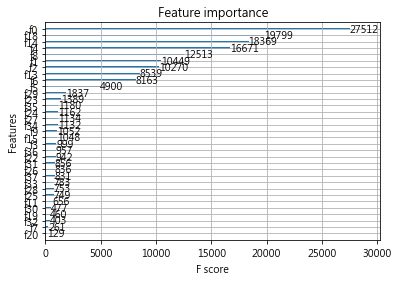

In [40]:
# Feature importance - xgboost

# 選出除了最後一欄的DataFrame (如果把Label放在最後一欄的話，就有效果了)
X = df.iloc[:, 1:].values  # 變成ndarray
y = df.iloc[:, 0].values # 那個3是他真的去數最後一欄在哪一個index

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X,y)

# importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
model.get_booster().get_score(importance_type='weight')

from xgboost import plot_importance
plot_importance(model)
plt.show()

In [54]:
# 早上8:30 start
from datetime import datetime
print(datetime.now())

2019-02-26 13:01:36.514213


In [78]:
df_20190220.ix[:, ["shape"]]

/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,shape
0,1
1,1
2,1
3,1
4,3
5,1
6,3
7,1
8,2
9,1


In [57]:
X_1 = df.iloc[:, 1:].values  # 變成ndarray
y = df.iloc[:, 0].values # 那個3是他真的去數最後一欄在哪一個index

importances = XGBClassifier().fit(X_1,y).feature_importances_
indices = np.argsort(importances)[-20:]
#
# indices = np.argsort(importances)[-9:]
indices

array([36,  3, 15,  9, 34, 27, 24, 35, 23, 29,  5,  6, 13,  2,  1,  8,  4,
       14, 18,  0])

In [65]:
df.iloc[:, [1,19,15,5,9,2,3,14,7,6,30,24,36,25,28,35,10,16,4,37]]

"""
area 	updatetime 	refreshtime 	browsenum_all 	browsenum 	floor 	allfloor 	photoNum 	len_condition 	len_living 	Section_大安區 	Section_信義區 	kind_雅房 	Section_內湖區 	Section_士林區 	kind_獨立套房 	checkstatus 	shape 	top_floor 	contact_仲介
"""

,area,updatetime,refreshtime,browsenum_all,browsenum,floor,allfloor,photoNum,len_condition,len_living,Section_大安區,Section_信義區,kind_雅房,Section_內湖區,Section_士林區,kind_獨立套房,checkstatus,shape,top_floor,contact_仲介
0,2.890372,1550046105,1550046105,8.630165,5.826000,1.945910,1.945910,4,4,7,1,0,0,0,0,0,0.000000,0.693147,1.0,0
1,2.302585,1550204020,1550452101,7.873598,4.787492,1.609438,1.609438,8,16,7,0,0,0,0,0,1,0.000000,0.693147,1.0,0
2,2.302585,1550565360,1550565360,5.365976,0.000000,1.098612,1.791759,7,17,7,0,0,0,0,0,0,0.000000,0.693147,0.0,0
3,2.772589,1550407525,1550594702,6.216606,5.459586,1.945910,1.791759,8,14,7,0,0,0,0,0,1,1.791759,0.693147,1.0,0
4,2.397895,1549860987,1549860987,5.273000,3.091042,1.098612,1.386294,14,17,7,0,0,0,0,1,0,0.693147,1.386294,0.0,0
5,4.262680,1548594807,1550066449,6.413459,3.218876,1.386294,1.386294,14,12,2,0,0,0,0,0,0,1.791759,1.386294,0.0,0
6,2.079442,1550160575,1550592602,7.401842,5.655992,1.386294,1.791759,3,14,6,0,1,0,0,0,1,0.693147,0.693147,0.0,0
7,2.541602,1549952191,1549952191,7.237778,5.105945,2.197225,2.639057,10,13,7,0,0,0,0,0,1,0.693147,1.098612,0.0,0
8,1.945910,1550298674,1550585702,6.888572,4.615121,1.098612,1.609438,3,11,4,0,0,0,0,0,1,0.000000,0.693147,0.0,0
9,2.197225,1550488487,1550582702,6.329721,3.610918,0.693147,0.693147,6,15,5,0,0,0,0,0,0,0.000000,0.693147,1.0,0


In [55]:
# 還原變數名稱
importances = model.feature_importances_
# indices = np.argsort(importances)[-20:]
#
indices = np.argsort(importances)[-9:]
indices
# X[indices]

array([4, 9, 0, 8, 5, 1, 6, 3, 2])

In [42]:
# indices

In [43]:
# index = indices + 1
# index = index.tolist()
# index

In [44]:
# X = X[[index]]
# X

In [45]:
# load data
X = df.iloc[:, 1:]
X = X.iloc[:, [18,4,0,8,14,13,1,5,2,6]].values  
y = df.iloc[:, 0].values

In [46]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 87)

# build model

# xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)
# xgb.fit(X_train,y_train)

model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

model.fit(X_train,y_train)

# OrderedDict(sorted(model.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.6)

In [47]:
def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

In [48]:
get_rmse(model)

0.2662932733714335

In [49]:
result = model.predict(X_test)
result

array([ 9.704295,  9.474133, 11.66655 , ...,  9.275344,  9.63151 ,
        8.958171], dtype=float32)

In [50]:
np.expm1(result)

array([ 16386.844 ,  13017.576 , 116604.266 , ...,  10670.628 ,
        15236.424 ,   7770.1304], dtype=float32)

In [51]:
# np.expm1(X)

In [52]:
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)


# for tuning parameters
# parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]}  

parameters_for_testing = {
   'colsample_bytree':[0.4,0.8],
   'gamma':[0,0.3],
   'min_child_weight':[1.5,6],
   'max_depth':[3,5],
   'reg_alpha':[1e-5, 1e-2],
   'reg_lambda':[1e-5, 1e-2],
   'subsample':[0.6,0.95]}  

# GridSearchCV
from sklearn.model_selection import GridSearchCV
    
gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=-1,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X_train, y_train)
print(gsearch1.grid_scores_)
print('best params')
print(gsearch1.best_params_)
print('best score')
print(gsearch1.best_score_)


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.05885109915676214, total=  18.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.05988895537918675, total=  21.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   40.5s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.06383879474832993, total=  18.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.7s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.061767045384994126, total=  15.9s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.0626384958439441, total=  17.5s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.05976579546678158, total=  14.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.05866468180202213, total=  14.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  2.0min remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.06408170481545793, total=  15.8s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.061540750955344926, total=  16.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.6min remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0618751470208163, total=  16.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.059910843483463025, total=  16.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.05935103925278873, total=  17.2s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0637971085099818, t

[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.06101121907955173, total=  17.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.062406738119347854, total=  17.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.058652780807085976, total=  17.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.05940250761729704, tota

[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.06162576281040529, total=  15.9s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.06268416602518366, total=  17.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.05879594777179012, total=  18.1s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.0597079951569978, total=  16.7s
[CV]

[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.061512374805003454, total=  25.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.061676597087782246, total=  26.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.06191122913675921, total=  27.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.0591099665561708

[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.06274568693859572, total=  22.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.061435630881604905, total=  26.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.06092932081382139, total=  25.4s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0603700371509885, total=

[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0623893482342002, total=  24.6s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.06066607619669435, total=  23.4s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.06109645410977585, total=  22.5s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.05968671745378769, total= 

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.05964519759372982, total=  14.9s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.06413076476276958, total=  14.2s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.061141524271449435, total=  15.0s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.06022265731901164, total=  14.4s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.05882245031841694, total=  14.1s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.06355855889079887, total=  14.7s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.06210967563182

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.06326891444241836, total=  25.4s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.060104185776110694, total=  24.1s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.057203586645952584, total=  25.4s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, s

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.06094924373640537, total=  25.5s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.06257079383985706, total=  26.0s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.06084637479142638, total=  26.5s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0577528590

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.06316368397985864, total=  24.4s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.05954598618739319, total=  27.5s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.0622544466439032, total=  25.0s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.060407446019439405, 

[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.05943110310600571, total=  21.6s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.06275431361863552, total=  21.5s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.06324610778430913, total=  22.7s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0621962221114351, tot

[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.0606724826533774, total=  20.8s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.059237666701122745, total=  19.7s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.06347556863694118, total=  19.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.06294916333653101, total=  2

[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.05976139765627368, total=  20.6s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.059545299281002884, total=  22.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.06309735970913428, total=  21.0s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.06295964323748768, total=  22.0s
[CV] col

[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.06073183437779133, total=  31.3s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.06028373061026842, total=  33.7s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.05841471952548054, total=  34.1s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.06360630440472297, t

[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.06164516028023891, total=  29.6s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0610360640068544, total=  31.4s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.05911967721214505, total=  31.1s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.057850749007904066, total=  31

[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.061263514535623155, total=  31.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.06097844249805672, total=  31.5s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.06018632686775671, total=  21.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.05925775849168

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.06301920326450156, total=  21.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.06313316193110684, total=  19.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.0635770425846359, total=  20.6s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.05999

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.060337190749141845, total=  20.9s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.0632721609525694, total=  19.0s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.06278765282451389, total=  19.7s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.06377100306940

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.059378766733250155, total=  32.1s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.05820625595804, total=  31.6s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.06244412006762769, total=  29.6s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, scor

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.06171523647053799, total=  32.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.059330620133447406, total=  33.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.05796594782562896, total=  30.0s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0616134

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.06212859106299544, total=  33.1s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.06201065534951575, total=  33.3s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.05864938153154265, total=  34.1s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.05813327195731419

[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 257.5min finished


[mean: -0.06140, std: 0.00181, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}, mean: -0.06119, std: 0.00186, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.95}, mean: -0.06147, std: 0.00164, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.6}, mean: -0.06082, std: 0.00143, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.95}, mean: -0.06139, std: 0.00183, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 0.01, 'reg_lambda': 1e-05, 'subsample': 0.6}, mean: -0.06102, std: 0.00156, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5

/home/js/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
"""
{'colsample_bytree': 0.4, 'gamma': 0.3, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.95}
best score
-0.06001792019694334
"""

In [53]:
# 早上8:30 start
from datetime import datetime
print(datetime.now())

2019-02-26 13:01:36.458862


## raw data head n = 100, GridSearchCV的結果

In [43]:
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)


# for tuning parameters
# parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]}  

parameters_for_testing = {
   'colsample_bytree':[0.4,0.8],
   'gamma':[0,0.3],
   'min_child_weight':[1.5,6],
   'max_depth':[3,5],
   'reg_alpha':[1e-5, 1e-2],
   'reg_lambda':[1e-5, 1e-2],
   'subsample':[0.6,0.95]}  

# GridSearchCV
from sklearn.model_selection import GridSearchCV
    
gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=-1,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X_train, y_train)
print(gsearch1.grid_scores_)
print('best params')
print(gsearch1.best_params_)
print('best score')
print(gsearch1.best_score_)


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.0015156484440458386, total=   3.6s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.004182641739955593, total=   3.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.0010645599925232954, total=   3.2s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.001535398093754685, total=   2.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   12.8s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.00044774908997235677, total=   3.1s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.001393364431056545, total=   3.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   19.2s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.004154561723563979, total=   2.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   21.9s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0009534572372613779, total=   2.8s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   24.7s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0013509153206685367, total=   2.9s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   27.6s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0005939693198105499, total=   2.9s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0014201615062491323, total=   2.6s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0032143268498718196, total=   3.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0011345317961

[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0015479031843354007, total=   2.7s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0005065127876014179, total=   2.9s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.001887166088429832, total=   2.9s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.0040046493848818155,

[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.0015065375503527532, total=   3.1s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.0005881274685301673, total=   4.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.001496780430303308, total=   3.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.003625092361439416, total=   3.

[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.001003619434718807, total=   3.3s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.0011060764010954564, total=   3.6s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.0005125583068945859, total=   3.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.00101923082

[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.003774973342579444, total=   3.2s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0008632122681360195, total=   3.8s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0016344443422741538, total=   3.8s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0006602654516787

[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0036536331785405524, total=   3.0s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0009485116992066281, total=   3.2s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0016199176956022687, total=   3.2s
[CV] colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0005451215185243792, total=  

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.002914552424053352, total=   3.4s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.008800670402335417, total=   4.1s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.00333751225415087, total=   4.3s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.002096298321723056, total=   4.3s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.002913935758856255, total=   3.9s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.008804995898352019, total=   4.4s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.003337019750

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.004037857482457269, total=   6.3s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.002096308208785084, total=   5.9s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0029139601953071413, total=   6.1s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, s

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.0033578159420239555, total=   5.6s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.004038096939172169, total=   5.6s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.0020966743497675107, total=   6.0s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0029145

[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.008780520686121784, total=   4.3s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.0033577926307359137, total=   3.5s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.004038087311790861, total=   3.5s
[CV] colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.4, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.00209654563469796

[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0009482648040909099, total=   2.8s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0025082767177468795, total=   2.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0006826777397940165, total=   2.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.001332672668187

[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0005300295223552901, total=   6.5s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.001338740887930174, total=   5.8s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.003455429973446083, total=   4.2s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.0009623854666787765, to

[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.0005331644920133031, total=   3.0s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.0013233467297191818, total=   3.0s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.003482833059927117, total=   2.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=3, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.0010476039328943295, total=   2.9s


[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.0013556916576760998, total=   2.4s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.0003953533151353208, total=   2.6s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.0009772631617198568, total=   3.2s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.001840059679

[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0007526820651695212, total=   3.1s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0014148709150487546, total=   3.4s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0005989825504421862, total=   2.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.6, score=-0.0013596892539381236

[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0006757218199104209, total=   2.8s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0014347167591229279, total=   2.9s
[CV] colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.0004951132448387786, total=   3.4s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.002941433622080856,

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.008800670402335417, total=   5.8s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.00333751225415087, total=   5.5s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.004056904094806172, total=   5.7s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.002913935758856255, total=   5.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.008804995898352019, total=   5.3s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.0033370197508271965, total=   4.9s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=6, reg_alpha=1e-05, reg_lambda=0.01, subsample=0.95, score=-0.0040572558

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-0.002096308208785084, total=   7.6s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.0029139601953071413, total=   7.4s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-0.008804411144489615, total=   8.7s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95,

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.004038096939172169, total=   7.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, score=-0.0020966743497675107, total=  10.3s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.002914513217047317, total=   8.2s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=1.5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.95, score=-0.008800

[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.0033577926307359137, total=   4.6s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.004038087311790861, total=   4.6s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.6, score=-0.002096545634697963, total=   5.5s
[CV] colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95 
[CV]  colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=6, reg_alpha=0.01, reg_lambda=1e-05, subsample=0.95, score=-0.002914552424053

[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 46.5min finished


[mean: -0.00175, std: 0.00128, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}, mean: -0.00169, std: 0.00127, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.95}, mean: -0.00150, std: 0.00091, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.6}, mean: -0.00160, std: 0.00117, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.95}, mean: -0.00125, std: 0.00069, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5, 'reg_alpha': 0.01, 'reg_lambda': 1e-05, 'subsample': 0.6}, mean: -0.00142, std: 0.00096, params: {'colsample_bytree': 0.4, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1.5

/home/js/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
"""
best params
{'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1.5, 'reg_alpha': 0.01, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-0.0011072420232027655
"""

In [321]:
every_col_non_categorical = [col for col in df.columns
               if col not in catedorical_features
               and col not in ["user_id", "cases_id"]]

In [322]:
numeric_feats = df[every_col_non_categorical].dtypes[(df.dtypes != "object") & (df.dtypes != "datetime64[ns]")].index
df[numeric_feats] = np.log1p(df[numeric_feats])
df[numeric_feats]

/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log1p
  
/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


,price,houseid,area,floor,allfloor,top_floor,browsenum_all,len_living,len_condition,isvip,...,new_list_comment_total,photoNum,refreshtime,shape,social_house,storeprice,updatetime,mvip,is_combine,hasimg
0,9.615872,13.942581,2.890372,1.945910,1.945910,0.693147,8.630165,2.079442,1.609438,0.000000,...,0.000000,1.609438,21.161551,0.693147,0.0,0.0,21.161551,0.000000,0.000000,0.693147
1,9.350189,14.100432,2.302585,1.609438,1.609438,0.693147,7.873598,2.079442,2.833213,0.000000,...,0.693147,2.197225,21.161812,0.693147,0.0,0.0,21.161652,0.000000,0.000000,0.693147
2,9.441531,14.616725,2.302585,1.098612,1.791759,0.000000,5.365976,2.079442,2.890372,0.000000,...,0.000000,2.079442,21.161885,0.693147,0.0,0.0,21.161885,0.000000,0.000000,0.693147
3,9.680406,14.620764,2.772589,4.615121,1.791759,0.000000,6.216606,2.079442,2.708050,0.693147,...,0.000000,2.197225,21.161904,0.693147,0.0,0.0,21.161784,0.693147,0.000000,0.693147
4,9.472782,14.657606,2.397895,1.098612,1.386294,0.000000,5.273000,2.079442,2.890372,0.000000,...,0.000000,2.708050,21.161431,1.386294,0.0,0.0,21.161431,0.000000,0.000000,0.693147
5,8.294300,14.711664,1.547563,0.000000,0.000000,NaN,4.997212,0.693147,1.791759,0.000000,...,0.000000,1.945910,21.161900,0.693147,0.0,0.0,21.161777,0.000000,0.000000,0.693147
6,10.645449,14.757500,4.262680,4.605170,1.386294,0.000000,6.413459,1.098612,2.564949,0.000000,...,0.000000,2.708050,21.161564,1.386294,0.0,0.0,21.160614,0.000000,0.000000,0.693147
7,9.190240,14.793316,2.079442,1.386294,1.791759,0.000000,7.401842,1.945910,2.708050,0.693147,...,0.693147,1.386294,21.161903,0.693147,0.0,0.0,21.161624,0.693147,0.000000,0.693147
8,9.615872,14.803506,2.541602,2.197225,2.639057,0.000000,7.237778,2.079442,2.639057,0.000000,...,1.609438,2.397895,21.161490,1.098612,0.0,0.0,21.161490,0.000000,0.000000,0.693147
9,8.922792,14.818966,1.945910,1.098612,1.609438,0.000000,6.888572,1.609438,2.484907,0.693147,...,0.000000,1.386294,21.161899,0.693147,0.0,0.0,21.161713,0.000000,0.000000,0.693147


In [ ]:
# df = pd.get_dummies(df, columns = catedorical_features)

In [343]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 39 columns):
price                     1001 non-null float64
houseid                   1001 non-null float64
fulladdress               1001 non-null object
kind_name                 1001 non-null object
layout                    1001 non-null object
area                      1001 non-null float64
floor                     1000 non-null float64
allfloor                  1001 non-null float64
top_floor                 943 non-null float64
region_name               1001 non-null object
section_name              1001 non-null object
address_img_title         1001 non-null object
browsenum_all             1001 non-null float64
nick_name                 1001 non-null object
house_living              1001 non-null object
len_living                1001 non-null float64
house_condition           1001 non-null object
len_condition             1001 non-null float64
isvip                     1001 non-null

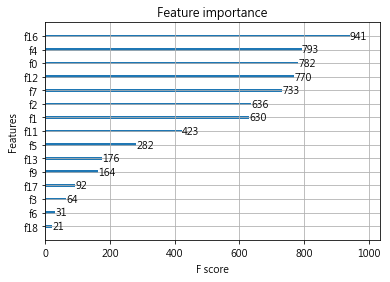

In [323]:
# load data
dataset = df.loc[0:1000, :]

from xgboost import XGBClassifier
X = dataset.iloc[:, [5,6,7,8,12,15,18,21,24,25,26,27,28,29,30,31,32,34,36,37]].values
# X = dataset.ix[:, 5:20].values

y = dataset.iloc[:, 10].values
model = XGBClassifier()
model.fit(X,y)

# importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
model.get_booster().get_score(importance_type='weight')



from xgboost import plot_importance
plot_importance(model)
plt.show()

In [23]:
# 2. accuracy
print("accuracy = %f " % (model.score(X, y)))

test_params = {
 'max_depth':[4,8,12]
}

model = GridSearchCV(estimator = model, param_grid = test_params)
model.fit(X, y)
print(model.best_params_)

/home/js/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy = 0.652348 


/home/js/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/js/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/js/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/js/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Return

{'max_depth': 8}


In [306]:
taipei_land = pd.read_csv("../591_house/Taipei_108_LandValue.txt", encoding = "utf-8")
taipei_land.head()

,AA45,AA46,AA48,AA49,AA16
0,臺北市,松山區,西松段一小段,10000,351000
1,臺北市,松山區,西松段一小段,20000,351000
2,臺北市,松山區,西松段一小段,30000,352469
3,臺北市,松山區,西松段一小段,40000,362012
4,臺北市,松山區,西松段一小段,50000,351000


In [11]:
"1001123"[0:-4]

'100'

In [271]:
taipei_land = pd.read_csv("../591_house/a_lvr_land_a_useful_col.csv")
taipei_land.head()

,鄉鎮市區,交易標的,土地區段位置建物區段門牌,都市土地使用分區,建築完成年月,單價元平方公尺
0,文山區,房地(土地+建物),臺北市文山區忠順街二段85巷1弄1~30號,住,780916.0,118400.0
1,中正區,車位,臺北市中正區重慶南路三段151~180號,住,1010315.0,NaN
2,文山區,房地(土地+建物),臺北市文山區溪口街107巷1~30號,住,750516.0,139810.0
3,文山區,房地(土地+建物),臺北市文山區辛亥路七段84巷1~30號,住,NaN,59412.0
4,文山區,房地(土地+建物),臺北市文山區木柵路二段109巷100弄31~60號,住,850925.0,117150.0


In [272]:
taipei_land.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 6 columns):
鄉鎮市區            331 non-null object
交易標的            331 non-null object
土地區段位置建物區段門牌    331 non-null object
都市土地使用分區        320 non-null object
建築完成年月          266 non-null float64
單價元平方公尺         305 non-null float64
dtypes: float64(2), object(4)
memory usage: 15.6+ KB


In [289]:
taipei_land_preprocess = taipei_land.copy()
taipei_land_preprocess = taipei_land_preprocess.loc[taipei_land_preprocess["交易標的"] != "車位", :] 
taipei_land_preprocess = taipei_land_preprocess.loc[taipei_land_preprocess["交易標的"] != "土地", :] 
taipei_land_preprocess.head()

,鄉鎮市區,交易標的,土地區段位置建物區段門牌,都市土地使用分區,建築完成年月,單價元平方公尺
0,文山區,房地(土地+建物),臺北市文山區忠順街二段85巷1弄1~30號,住,780916.0,118400.0
2,文山區,房地(土地+建物),臺北市文山區溪口街107巷1~30號,住,750516.0,139810.0
3,文山區,房地(土地+建物),臺北市文山區辛亥路七段84巷1~30號,住,NaN,59412.0
4,文山區,房地(土地+建物),臺北市文山區木柵路二段109巷100弄31~60號,住,850925.0,117150.0
5,文山區,房地(土地+建物),臺北市文山區景華街3巷1~30號,商,720709.0,146962.0


In [290]:
taipei_land_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 0 to 329
Data columns (total 6 columns):
鄉鎮市區            280 non-null object
交易標的            280 non-null object
土地區段位置建物區段門牌    280 non-null object
都市土地使用分區        271 non-null object
建築完成年月          245 non-null float64
單價元平方公尺         280 non-null float64
dtypes: float64(2), object(4)
memory usage: 15.3+ KB


In [291]:
# a = taipei_land_preprocess.loc[taipei_land_preprocess["土地區段位置建物區段門牌"].str.contains(r'^(?=.*街)(?=.*巷)'), :]["土地區段位置建物區段門牌"].apply(lambda x : x.split("區")[1])
# a

In [292]:
# taipei_land_preprocess["土地區段位置建物區段門牌"] = taipei_land_preprocess["土地區段位置建物區段門牌"].apply(lambda x : x[7:])
taipei_land_preprocess["土地區段位置建物區段門牌"] = taipei_land_preprocess["土地區段位置建物區段門牌"].apply(lambda x : x.split("區")[1])

taipei_land_preprocess["土地區段位置建物區段門牌"] = taipei_land_preprocess["土地區段位置建物區段門牌"]

taipei_land_preprocess = taipei_land_preprocess.reset_index(drop = True)
taipei_land_preprocess["路or街名"] = pd.Series()

a = list(taipei_land_preprocess["土地區段位置建物區段門牌"])

# .find('嗨')找不到那個字，回傳的index就是-1
for i in range(0, len(a)) :
    ind = a[i].find('路')
    if ind == -1 :
        ind = a[i].find('街')
        
    if ind != -1 :
        taipei_land_preprocess["路or街名"][i] = taipei_land_preprocess["土地區段位置建物區段門牌"][i][0:( ind +1 )]
    else :
        continue

taipei_land_preprocess

/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/js/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,鄉鎮市區,交易標的,土地區段位置建物區段門牌,都市土地使用分區,建築完成年月,單價元平方公尺,路or街名
0,文山區,房地(土地+建物),忠順街二段85巷1弄1~30號,住,780916.0,118400.0,忠順街
1,文山區,房地(土地+建物),溪口街107巷1~30號,住,750516.0,139810.0,溪口街
2,文山區,房地(土地+建物),辛亥路七段84巷1~30號,住,NaN,59412.0,辛亥路
3,文山區,房地(土地+建物),木柵路二段109巷100弄31~60號,住,850925.0,117150.0,木柵路
4,文山區,房地(土地+建物),景華街3巷1~30號,商,720709.0,146962.0,景華街
5,文山區,房地(土地+建物),保儀路109巷3弄31~60號,住,660105.0,118193.0,保儀路
6,文山區,房地(土地+建物),辛亥路四段77巷92弄1~30號,住,920922.0,136421.0,辛亥路
7,文山區,房地(土地+建物)+車位,汀州路四段241~270號,住,991104.0,139236.0,汀州路
8,中正區,房地(土地+建物)+車位,南海路31~60號,住,961017.0,169305.0,南海路
9,中正區,房地(土地+建物)+車位,辛亥路一段1~30號,住,1070717.0,276669.0,辛亥路


In [293]:
taipei_land_preprocess.loc[231:233, :]

,鄉鎮市區,交易標的,土地區段位置建物區段門牌,都市土地使用分區,建築完成年月,單價元平方公尺,路or街名
231,南港區,房地(土地+建物)+車位,園,住,1000414.0,181855.0,NaN
232,信義區,房地(土地+建物)+車位,松仁路308巷91~120號,住,1030418.0,237515.0,松仁路
233,信義區,房地(土地+建物),吳興街361巷23弄1~30號,住,NaN,271512.0,吳興街


In [294]:
taipei_land.loc[taipei_land["單價元平方公尺"] == 181855,:]

,鄉鎮市區,交易標的,土地區段位置建物區段門牌,都市土地使用分區,建築完成年月,單價元平方公尺
275,南港區,房地(土地+建物)+車位,臺北市南港區園區街31~60號,住,1000414.0,181855.0


In [295]:
df = taipei_land_preprocess.copy().tail(50)

In [313]:
print(df.groupby(["鄉鎮市區", "路or街名"])["單價元平方公尺"].median().to_frame().reset_index().shape)
df.groupby(["鄉鎮市區", "路or街名"])["單價元平方公尺"].median().to_frame().reset_index()

(29, 3)


,鄉鎮市區,路or街名,單價元平方公尺
0,中山區,大直街,289564.0
1,中山區,建國北路,164449.0
2,中山區,林森北路,117489.0
3,中山區,民權東路,319308.0
4,中山區,錦州街,147000.0
5,中山區,龍江路,110419.0
6,中正區,中華路,260154.0
7,中正區,信義路,341420.0
8,中正區,延平南路,99915.0
9,中正區,杭州南路,179083.0


In [232]:
# # a = ["樂群三路31~60號", "林森北路85巷31~60號", "仁愛路二段20巷1~30號"]
# a = list(taipei_land_preprocess["土地區段位置建物區段門牌"])

# ind_路 = []
# ind_街 = []
# ind_段 = []
# ind_巷 = []
# ind_號 = []
# # .find('嗨')找不到那個字，回傳的index就是-1
# for i in range(0, len(a)) :
#     ind_路.append(a[i].find('路'))
#     ind_街.append(a[i].find('街'))
#     ind_段.append(a[i].find('段'))
#     ind_巷.append(a[i].find('巷'))
#     ind_號.append(a[i].find('號'))

# taipei_land_preprocess["路"] = ind_路
# taipei_land_preprocess["路名"] = pd.Series()
# taipei_land_preprocess["街"] = ind_街
# taipei_land_preprocess["街名"] = pd.Series()
# taipei_land_preprocess["段"] = ind_段
# taipei_land_preprocess["段名"] = pd.Series()
# taipei_land_preprocess["巷"] = ind_巷
# taipei_land_preprocess["巷名"] = pd.Series()
# taipei_land_preprocess["號"] = ind_號
# taipei_land_preprocess["號名"] = pd.Series()

# taipei_land_preprocess = taipei_land_preprocess.reset_index(drop = True)
# taipei_land_preprocess.head()

# df = taipei_land_preprocess.copy()
# df

# for i in range(0, df.shape[0]) :
#     if df["路"][i] != -1 :
#         df["路名"][i] = df["土地區段位置建物區段門牌"][i][0:( int(df["路"][i]) +1 )]
#     else :
# #         df["路"][i] = None
#         df["街名"][i] = df["土地區段位置建物區段門牌"][i][0:( int(df["街"][i]) +1 )]

# for i in range(0, df.shape[0]) :
#     if df["路"][i] != -1 :
#         if df["路"][i]
#         df["路名"][i] = df["土地區段位置建物區段門牌"][i][0:( int(df["路"][i]) +1 )]
#     else :
# #         df["路"][i] = None
#         df["街名"][i] = df["土地區段位置建物區段門牌"][i][0:( int(df["街"][i]) +1 )]

# df.isnull().sum()

In [233]:
["樂群三路31~60號", "仁愛路二段20巷1~30號"][0].find('路')

3

In [103]:
"樂群三路31~60號"[0:3]

'樂群三'